In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from src.constant import PROCESSED_DATA_DIR
from src.split import get_n_splits, permutate_df_by_cost_decreasing

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


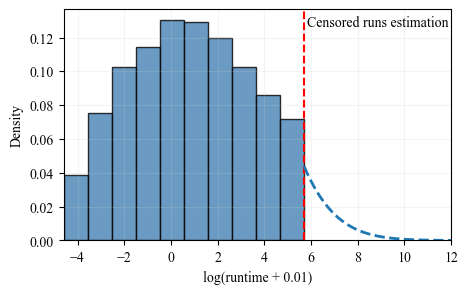

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))

n, bins, patches = ax.hist(
    np.log(df.loc[df["cost"] < 300, "cost"] + 0.01),
    bins=10,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
    density=True,
)
ax.axvline(x=np.log(300 + 0.01), color="red", linestyle="--", label="300 seconds")

z = np.linspace(np.log(300 + 0.01), 12, 1000)
y = 1 - stats.norm.cdf(z, loc=0.75, scale=2.9)
ax.plot(z, y, ls='--', linewidth=2)

ax.set_xlabel('log(runtime + 0.01)')
ax.set_ylabel('Density')
ax.text(8.85, 0.129, "Censored runs estimation", va="center", ha="center")
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

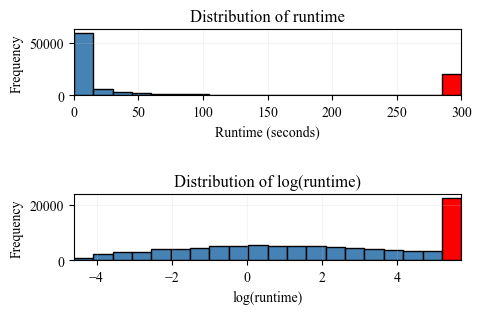

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor('red') 

ax1.set_title('Distribution of runtime')
ax1.set_xlabel('Runtime (seconds)')
ax1.set_ylabel('Frequency')

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor('red') 

ax2.set_title('Distribution of log(runtime)')
ax2.set_xlabel('log(runtime)')
ax2.set_ylabel('Frequency')

plt.subplots_adjust(hspace=1.5)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

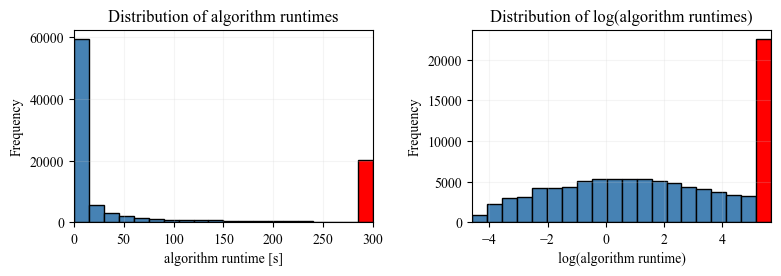

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor("red")

ax1.set_title("Distribution of algorithm runtimes")
ax1.set_xlabel("algorithm runtime [s]")
ax1.set_ylabel("Frequency")

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor("red")

ax2.set_title("Distribution of log(algorithm runtimes)")
ax2.set_xlabel("log(algorithm runtime)")
ax2.set_ylabel("Frequency")

plt.subplots_adjust(wspace=0.33)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

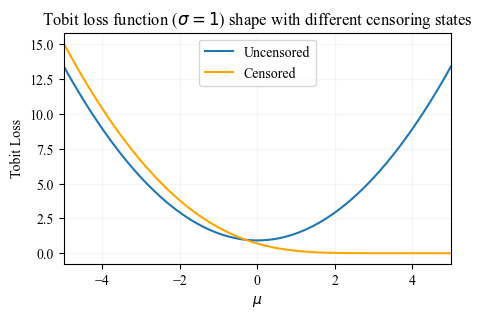

In [6]:
def tobit_loss_numpy(mu, std, c, I):
    z = (c - mu) / std
    uncensored_logpdf = -0.5 * z**2 - 0.5 * np.log(2 * np.pi)
    from scipy import special
    censored_logcdf = special.log_ndtr(-z)  # log(1-Φ(z)) = log(Φ(-z))
    loss = (1 - I) * uncensored_logpdf + I * censored_logcdf
    return -np.mean(loss)

mus = np.linspace(-5, 5, 1000)
std = 1
c = 0
values_i0 = [tobit_loss_numpy(mu, std, c, 0) for mu in mus]
values_i1 = [tobit_loss_numpy(mu, std, c, 1) for mu in mus]

plt.figure(figsize=(5, 3))
plt.plot(mus, values_i0, label='Uncensored')
plt.plot(mus, values_i1, color="orange", label='Censored')

plt.xlabel(r'$\mu$')
plt.ylabel('Tobit Loss')
plt.title(r'Tobit loss function ($\sigma=1$) shape with different censoring states')
plt.legend()
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

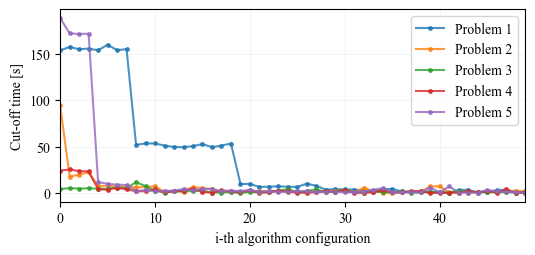

In [7]:
train_idx, test_idx = get_n_splits(df, n=2, instance_number=5, solver_number=100, random_state=0)[0]

df_train_test = df.loc[np.concatenate([train_idx, test_idx])]

df_train_test, cut_off_train_test = permutate_df_by_cost_decreasing(
    df_train_test, 
    lognormal_mean=0,
    lognormal_sigma=1,
    random_state=9
)

is_train = df_train_test.index.isin(train_idx)
is_test = df_train_test.index.isin(test_idx)

df_train = df_train_test.loc[is_train]
cut_off_train = cut_off_train_test[is_train]
df_test = df_train_test.loc[is_test]
cut_off_test = cut_off_train_test[is_test]


fig, ax = plt.subplots(figsize=(6, 2.5))
for i in range(5):
    ax.plot(cut_off_test[i::5], label=f"Problem {i+1}", marker=".", markersize=5, linestyle="-", alpha=0.8)

ax.legend()
ax.set_xlabel("i-th algorithm configuration")
ax.set_ylabel("Cut-off time [s]")
# ax.set_title("Cut-off time for 5 problem instances and for 50 solvers")
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()